In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw
from tqdm import tqdm

In [2]:
class TumorsDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_path, label = self.data_list.iloc[idx]
        image = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [3]:
def fix_label(label, img_size):
    x, y, w, h = label
    w = w / img_size[0]
    h = h / img_size[1]
    return x, y, w, h

In [13]:
def fix_label(label, img_size):
    x, y, w, h = label
    xmin = (x - w / 2) * img_size[0]
    ymin = (y - h / 2) * img_size[1]
    xmax = (x + w / 2) * img_size[0]
    ymax = (y + h / 2) * img_size[1]
    return xmin, ymin, xmax, ymax

In [14]:
def read_dataset(data_dir):
    data_list = pd.DataFrame(columns=['image_path', 'label'])
    img_dir = os.path.join(data_dir, 'images')
    for root, _, files in os.walk(img_dir):
        for i, file in enumerate(files):
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                label_name = image_path.replace('.jpg', '.txt')
                label_path = os.path.join(data_dir, 'labels', label_name.split('/')[-1] )
                with open(label_path, 'r') as f:
                    label = f.readline().strip().split()[1:]
                    label = [float(x) for x in label]
                    if len(label) == 0:
                        continue
                    label = fix_label(label, (132, 139))
                    data_list.loc[i] = [image_path, label]
                    
    return data_list

In [15]:
train_path = os.path.join(os.getcwd(), 'Clean', 'train')
test_path = os.path.join(os.getcwd(), 'Clean', 'test')

train_data_list = read_dataset(train_path)
test_data_list = read_dataset(test_path)

train_data_list.head()

,image_path,label
0,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(21.84172661870504, 71.60606060606061, 91.1654..."
1,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(35.13669064748201, 3.15909090909091, 96.86330..."
2,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(45.58273381294964, 26.325757575757574, 51.280..."
3,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(8.54676258992806, 62.12878787878788, 63.62589..."
4,/Users/benarviv/Documents/OpenU/2024א/Data Sci...,"(5.697841726618704, 18.954545454545453, 37.985..."


In [16]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = TumorsDataset(train_data_list, transform=transform)
test_dataset = TumorsDataset(test_data_list, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(132 * 139 * 3, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 4)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [23]:
model = nn.Sequential(
    nn.Conv2d(3, 16, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 32, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, 1, 1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Dropout(0.4),
    nn.Linear(64 * 17 * 16, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 4)    
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [26]:
epochs = 50
train_losses = []

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
    print(f'Epoch {epoch}, Loss {loss.item()}')

  2%|▏         | 1/50 [00:36<29:31, 36.16s/it]

Epoch 0, Loss 1084.1539306640625


  4%|▍         | 2/50 [01:11<28:31, 35.65s/it]

Epoch 1, Loss 1182.678955078125


  6%|▌         | 3/50 [01:46<27:44, 35.41s/it]

Epoch 2, Loss 667.4076538085938


  8%|▊         | 4/50 [02:22<27:15, 35.56s/it]

Epoch 3, Loss 665.2059936523438


 10%|█         | 5/50 [02:58<26:48, 35.75s/it]

Epoch 4, Loss 697.3418579101562


 12%|█▏        | 6/50 [03:35<26:25, 36.03s/it]

Epoch 5, Loss 576.7161865234375


 14%|█▍        | 7/50 [04:10<25:47, 35.98s/it]

Epoch 6, Loss 527.064208984375


 16%|█▌        | 8/50 [04:46<25:03, 35.80s/it]

Epoch 7, Loss 674.2446899414062


 18%|█▊        | 9/50 [05:22<24:29, 35.83s/it]

Epoch 8, Loss 361.3831787109375


 20%|██        | 10/50 [05:57<23:51, 35.78s/it]

Epoch 9, Loss 542.947265625


 22%|██▏       | 11/50 [06:33<23:16, 35.81s/it]

Epoch 10, Loss 648.5977783203125


 24%|██▍       | 12/50 [07:08<22:30, 35.55s/it]

Epoch 11, Loss 366.57501220703125


 26%|██▌       | 13/50 [07:43<21:47, 35.35s/it]

Epoch 12, Loss 555.188232421875


 28%|██▊       | 14/50 [08:18<21:05, 35.15s/it]

Epoch 13, Loss 454.55242919921875


 30%|███       | 15/50 [08:53<20:31, 35.18s/it]

Epoch 14, Loss 436.0536804199219


 32%|███▏      | 16/50 [09:28<19:52, 35.07s/it]

Epoch 15, Loss 486.57562255859375


 34%|███▍      | 17/50 [10:02<19:09, 34.82s/it]

Epoch 16, Loss 299.2516174316406


 36%|███▌      | 18/50 [10:37<18:34, 34.84s/it]

Epoch 17, Loss 393.7398376464844


 38%|███▊      | 19/50 [11:12<18:02, 34.92s/it]

Epoch 18, Loss 571.7869262695312


 40%|████      | 20/50 [11:47<17:28, 34.96s/it]

Epoch 19, Loss 432.70281982421875


 42%|████▏     | 21/50 [12:23<17:01, 35.23s/it]

Epoch 20, Loss 327.666015625


 44%|████▍     | 22/50 [12:58<16:28, 35.29s/it]

Epoch 21, Loss 567.6698608398438


 46%|████▌     | 23/50 [13:33<15:50, 35.21s/it]

Epoch 22, Loss 314.55364990234375


 48%|████▊     | 24/50 [14:09<15:20, 35.41s/it]

Epoch 23, Loss 379.3887023925781


 50%|█████     | 25/50 [14:46<14:56, 35.86s/it]

Epoch 24, Loss 388.6777038574219


 52%|█████▏    | 26/50 [15:22<14:18, 35.77s/it]

Epoch 25, Loss 299.95391845703125


 54%|█████▍    | 27/50 [15:57<13:41, 35.72s/it]

Epoch 26, Loss 318.15533447265625


 56%|█████▌    | 28/50 [16:33<13:02, 35.59s/it]

Epoch 27, Loss 316.48321533203125


 58%|█████▊    | 29/50 [17:08<12:24, 35.44s/it]

Epoch 28, Loss 274.1426086425781


 60%|██████    | 30/50 [17:43<11:48, 35.44s/it]

Epoch 29, Loss 268.5581359863281


 62%|██████▏   | 31/50 [18:18<11:10, 35.29s/it]

Epoch 30, Loss 251.94461059570312


 64%|██████▍   | 32/50 [18:53<10:31, 35.06s/it]

Epoch 31, Loss 289.82830810546875


 66%|██████▌   | 33/50 [19:27<09:52, 34.87s/it]

Epoch 32, Loss 257.3540954589844


 68%|██████▊   | 34/50 [20:02<09:15, 34.75s/it]

Epoch 33, Loss 333.9105529785156


 70%|███████   | 35/50 [20:36<08:39, 34.65s/it]

Epoch 34, Loss 391.1564025878906


 72%|███████▏  | 36/50 [21:10<08:04, 34.58s/it]

Epoch 35, Loss 311.7483215332031


 74%|███████▍  | 37/50 [21:45<07:28, 34.52s/it]

Epoch 36, Loss 328.3216857910156


 76%|███████▌  | 38/50 [22:19<06:53, 34.48s/it]

Epoch 37, Loss 244.93724060058594


 78%|███████▊  | 39/50 [22:54<06:18, 34.45s/it]

Epoch 38, Loss 306.0287780761719


 80%|████████  | 40/50 [23:28<05:44, 34.48s/it]

Epoch 39, Loss 255.5856475830078


 82%|████████▏ | 41/50 [24:03<05:10, 34.51s/it]

Epoch 40, Loss 264.24591064453125


 84%|████████▍ | 42/50 [24:37<04:36, 34.51s/it]

Epoch 41, Loss 282.71405029296875


 86%|████████▌ | 43/50 [25:12<04:01, 34.52s/it]

Epoch 42, Loss 288.73199462890625


 88%|████████▊ | 44/50 [25:46<03:27, 34.51s/it]

Epoch 43, Loss 270.69671630859375


 90%|█████████ | 45/50 [26:21<02:52, 34.52s/it]

Epoch 44, Loss 355.2046813964844


 92%|█████████▏| 46/50 [26:55<02:18, 34.51s/it]

Epoch 45, Loss 277.0268859863281


 94%|█████████▍| 47/50 [27:30<01:43, 34.49s/it]

Epoch 46, Loss 468.2618713378906


 96%|█████████▌| 48/50 [28:04<01:08, 34.46s/it]

Epoch 47, Loss 210.27822875976562


 98%|█████████▊| 49/50 [28:39<00:34, 34.48s/it]

Epoch 48, Loss 375.39202880859375


100%|██████████| 50/50 [29:13<00:00, 35.07s/it]

Epoch 49, Loss 272.0945739746094


In [27]:
def bbox_iou(box1, box2):
    # Calculate the coordinates of the intersection of the two boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # Calculate the area of the intersection
    intersection = max(0, abs(x2 - x1)) * max(0, abs(y2 - y1))

    # Calculate the area of each box
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the IoU
    iou = intersection / (box1_area + box2_area - intersection)

    return iou

model.eval()
true_boxes = []
predicted_boxes = []
correct = 0

with torch.no_grad():
    for data in tqdm(test_loader):
        images, labels = data
        outputs = model(images)
        true_boxes.extend(labels)
        predicted_boxes.extend(outputs)

        # Calculate the IoU for each prediction
        ious = [bbox_iou(output, label) for output, label in zip(outputs, labels)]

        # Consider a prediction to be "correct" if its IoU is above 0.5
        correct += sum(iou > 0.5 for iou in ious)

print(f'Number of correct predictions: {correct}')

100%|██████████| 31/31 [00:02<00:00, 13.56it/s]

Number of correct predictions: 484


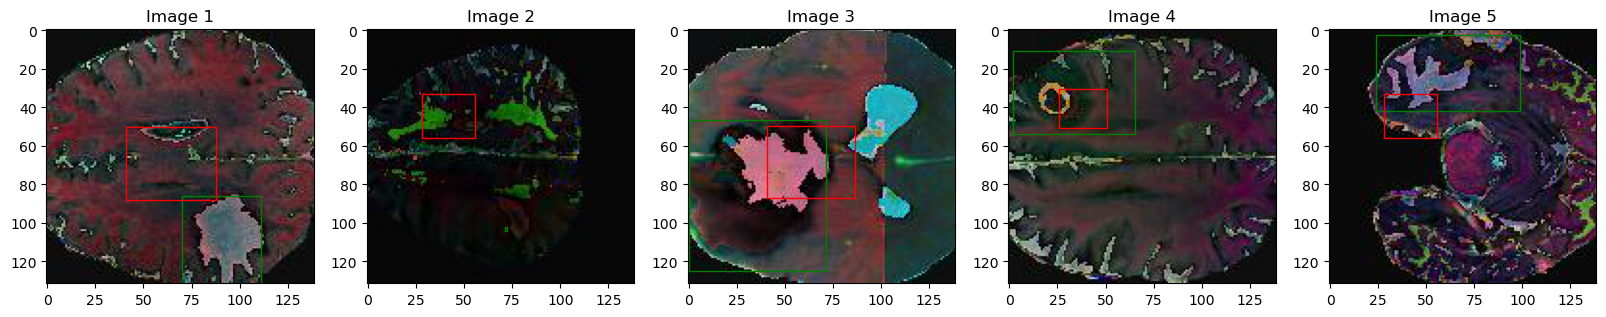

In [19]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Assuming you have a trained model named 'model' and a test loader named 'test_loader'

# Set the model to evaluation mode
model.eval()

# Get a batch of test data
test_data = next(iter(test_loader))

# Extract the images and labels from the test data
images, labels = test_data

# Make predictions using the model
with torch.no_grad():
    predictions = model(images)

# Convert the predictions to bounding boxes
# Assuming the predictions are in the format [x, y, width, height]
predicted_bboxes = predictions.detach().numpy()

# Convert the images to numpy arrays
image_arrays = images.detach().numpy().transpose(0, 2, 3, 1)

# Plot the images with true and predicted bounding boxes
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axes):
    # Convert the image array to PIL Image
    image = F.to_pil_image(image_arrays[i])
    
    # Get the image size
    image_width, image_height = image.size

    # Plot the image
    ax.imshow(image)

    # Get the true bounding box
    true_bbox = labels[i].detach().numpy()

    # Get the predicted bounding box
    pred_bbox = predicted_bboxes[i]

    # Plot the true bounding box
    true_xmin, true_ymin, true_xmax, true_ymax = true_bbox
    true_width = true_xmax - true_xmin
    true_height = true_ymax - true_ymin
    true_rect = plt.Rectangle((true_xmin, true_ymin), true_width, true_height, fill=False, color='green')
    ax.add_patch(true_rect)

    # Plot the predicted bounding box
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
    pred_width = pred_xmax - pred_xmin
    pred_height = pred_ymax - pred_ymin
    pred_rect = plt.Rectangle((pred_xmin, pred_ymin), pred_width, pred_height, fill=False, color='red')
    ax.add_patch(pred_rect)

    # Set the title of the subplot
    ax.set_title(f"Image {i+1}")

# Show the plot
plt.show()

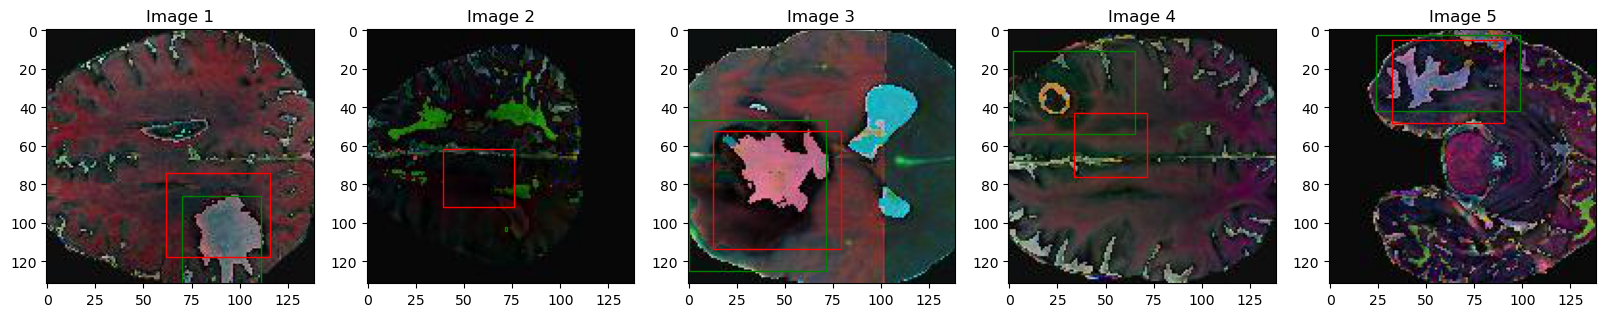

In [28]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Assuming you have a trained model named 'model' and a test loader named 'test_loader'

# Set the model to evaluation mode
model.eval()

# Get a batch of test data
test_data = next(iter(test_loader))

# Extract the images and labels from the test data
images, labels = test_data

# Make predictions using the model
with torch.no_grad():
    predictions = model(images)

# Convert the predictions to bounding boxes
# Assuming the predictions are in the format [x, y, width, height]
predicted_bboxes = predictions.detach().numpy()

# Convert the images to numpy arrays
image_arrays = images.detach().numpy().transpose(0, 2, 3, 1)

# Plot the images with true and predicted bounding boxes
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, ax in enumerate(axes):
    # Convert the image array to PIL Image
    image = F.to_pil_image(image_arrays[i])
    
    # Get the image size
    image_width, image_height = image.size

    # Plot the image
    ax.imshow(image)

    # Get the true bounding box
    true_bbox = labels[i].detach().numpy()

    # Get the predicted bounding box
    pred_bbox = predicted_bboxes[i]

    # Plot the true bounding box
    true_xmin, true_ymin, true_xmax, true_ymax = true_bbox
    true_width = true_xmax - true_xmin
    true_height = true_ymax - true_ymin
    true_rect = plt.Rectangle((true_xmin, true_ymin), true_width, true_height, fill=False, color='green')
    ax.add_patch(true_rect)

    # Plot the predicted bounding box
    pred_xmin, pred_ymin, pred_xmax, pred_ymax = pred_bbox
    pred_width = pred_xmax - pred_xmin
    pred_height = pred_ymax - pred_ymin
    pred_rect = plt.Rectangle((pred_xmin, pred_ymin), pred_width, pred_height, fill=False, color='red')
    ax.add_patch(pred_rect)

    # Set the title of the subplot
    ax.set_title(f"Image {i+1}")

# Show the plot
plt.show()